In [ ]:
eta = 0.50
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 12
n_center = 10
l = 5

num_layers = 30
width = 512

n_max_mirror_iterations=15       # num mirror steps
n_max_iterations=2000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100



In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=2b2a61c2e9bd6c90a477fc351cf9a62df680e271bfd04265959930eed69c5d7c
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


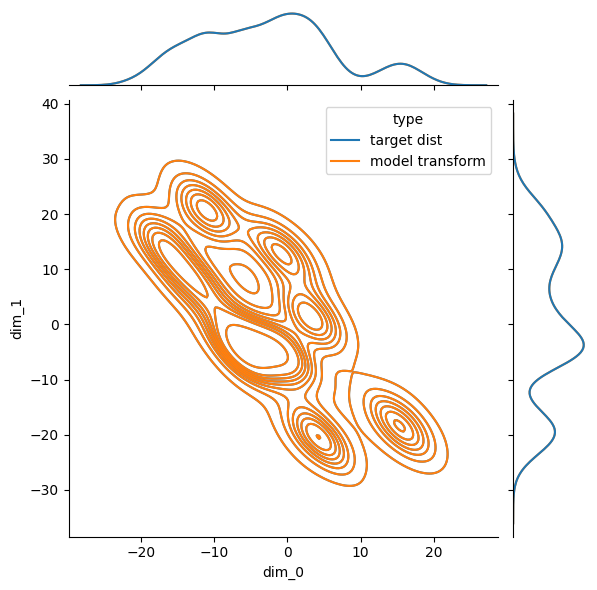

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])

trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]

Loss: 38.049156188964844


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


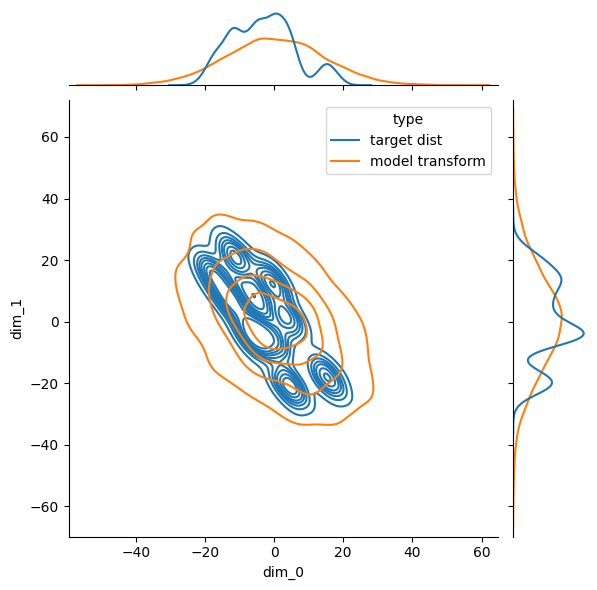

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

 50%|█████     | 1000/2000 [14:18<15:51,  1.05it/s]

trail: 0 m step: 0 Loss: 30.0532169342041  L_n: 9.007265090942383  kld: 10.52297592163086 KLD1: 8.994460105895996 KLD2: 18.13786506652832


100%|██████████| 2000/2000 [28:36<00:00,  1.17it/s]

trail: 0 m step: 0 Loss: 27.89470100402832  L_n: 7.514753341674805  kld: 10.189973831176758 KLD1: 7.425887107849121 KLD2: 20.423444747924805



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


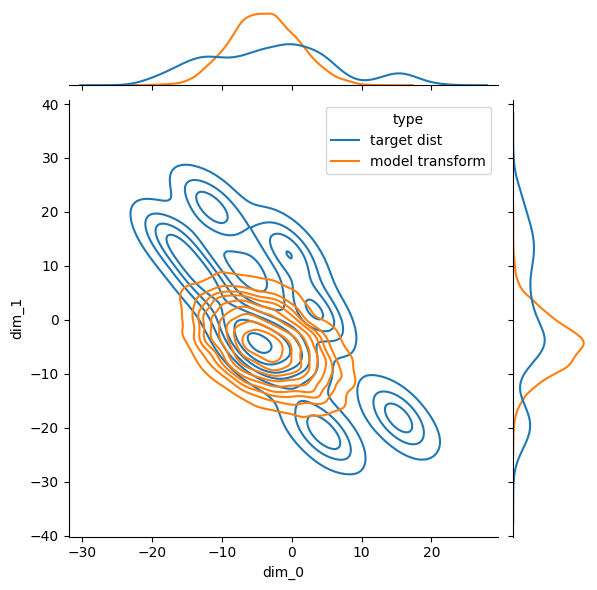

trail: 0 m step: 0 kl_test: 7.466224670410156


 50%|█████     | 1000/2000 [14:21<15:55,  1.05it/s]

trail: 0 m step: 1 Loss: 4.350992202758789  L_n: 2.9545955657958984  kld: 0.6981983184814453 KLD1: 2.9181995391845703 KLD2: 34.23492431640625


100%|██████████| 2000/2000 [28:42<00:00,  1.16it/s]

trail: 0 m step: 1 Loss: 4.271068572998047  L_n: 2.831989288330078  kld: 0.7195396423339844 KLD1: 2.7817273139953613 KLD2: 31.394420623779297



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


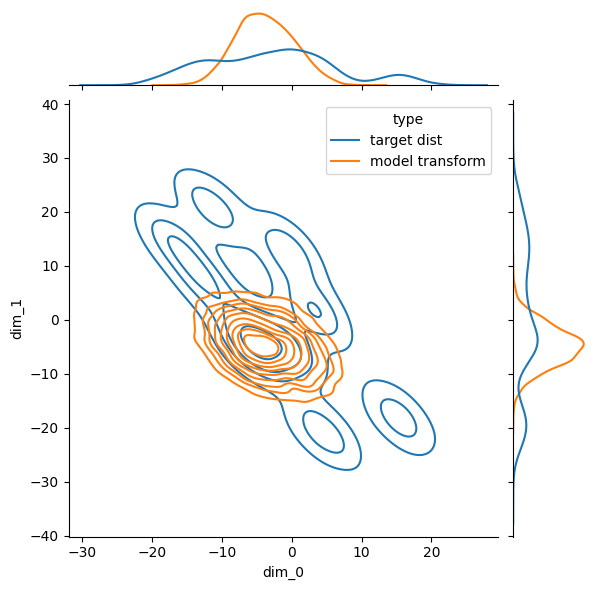

trail: 0 m step: 1 kl_test: 2.815418243408203


 50%|█████     | 1000/2000 [14:23<16:00,  1.04it/s]

trail: 0 m step: 2 Loss: 2.2456817626953125  L_n: 1.8632698059082031  kld: 0.1912059783935547 KLD1: 1.8367112874984741 KLD2: 40.50218200683594


100%|██████████| 2000/2000 [28:46<00:00,  1.16it/s]

trail: 0 m step: 2 Loss: 2.214113235473633  L_n: 1.846120834350586  kld: 0.18399620056152344 KLD1: 1.8282428979873657 KLD2: 41.68012237548828



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


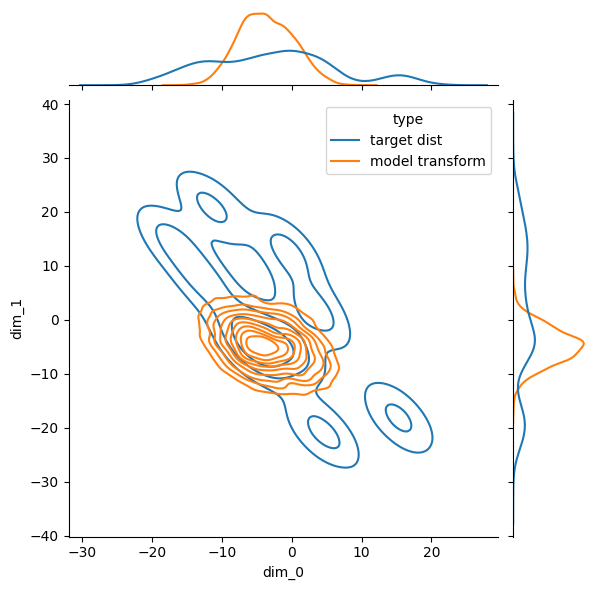

trail: 0 m step: 2 kl_test: 1.8316497802734375


 50%|█████     | 1000/2000 [14:24<16:00,  1.04it/s]

trail: 0 m step: 3 Loss: 1.645120620727539  L_n: 1.5261516571044922  kld: 0.05948448181152344 KLD1: 1.5156608819961548 KLD2: 48.12879180908203


100%|██████████| 2000/2000 [28:48<00:00,  1.16it/s]

trail: 0 m step: 3 Loss: 1.6512622833251953  L_n: 1.5046825408935547  kld: 0.07328987121582031 KLD1: 1.4892315864562988 KLD2: 48.43577194213867



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


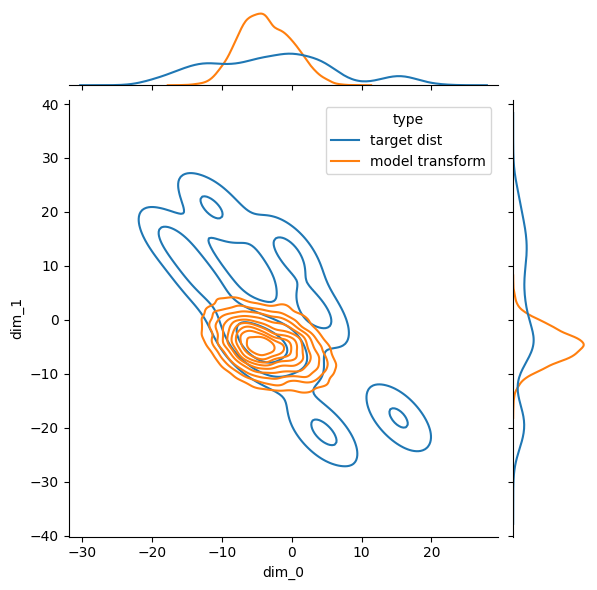

trail: 0 m step: 3 kl_test: 1.5027217864990234


 50%|█████     | 1000/2000 [14:26<16:01,  1.04it/s]

trail: 0 m step: 4 Loss: 1.4227218627929688  L_n: 1.3705291748046875  kld: 0.026096343994140625 KLD1: 1.3754240274429321 KLD2: 52.52151107788086


100%|██████████| 2000/2000 [28:52<00:00,  1.15it/s]

trail: 0 m step: 4 Loss: 1.4228801727294922  L_n: 1.366659164428711  kld: 0.028110504150390625 KLD1: 1.3628313541412354 KLD2: 52.64240646362305



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


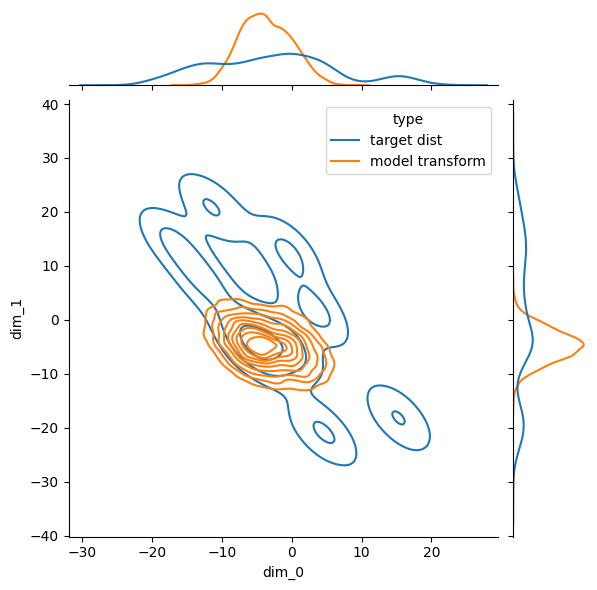

trail: 0 m step: 4 kl_test: 1.361501693725586


 50%|█████     | 1000/2000 [14:25<16:00,  1.04it/s]

trail: 0 m step: 5 Loss: 1.3578300476074219  L_n: 1.3304710388183594  kld: 0.01367950439453125 KLD1: 1.335220456123352 KLD2: 55.30195999145508


100%|██████████| 2000/2000 [28:50<00:00,  1.16it/s]

trail: 0 m step: 5 Loss: 1.3377914428710938  L_n: 1.3049468994140625  kld: 0.016422271728515625 KLD1: 1.2955455780029297 KLD2: 56.075862884521484



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


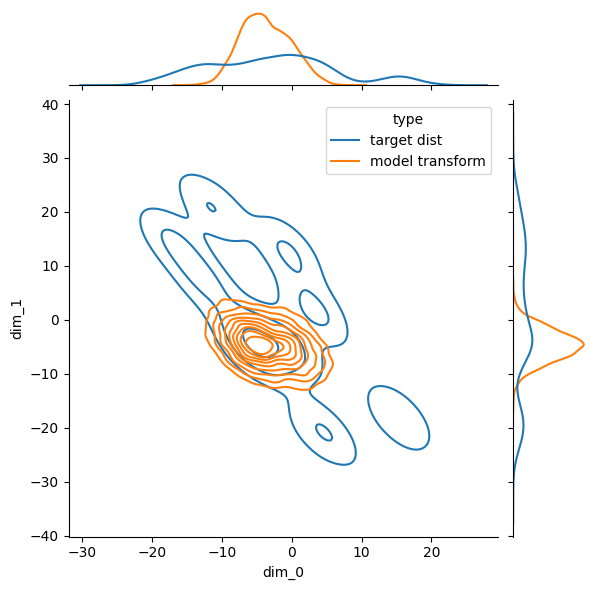

trail: 0 m step: 5 kl_test: 1.3039932250976562


 50%|█████     | 1000/2000 [14:22<15:57,  1.04it/s]

trail: 0 m step: 6 Loss: 1.2986717224121094  L_n: 1.2749786376953125  kld: 0.011846542358398438 KLD1: 1.274896264076233 KLD2: 60.13438415527344


100%|██████████| 2000/2000 [28:43<00:00,  1.16it/s]

trail: 0 m step: 6 Loss: 1.2968730926513672  L_n: 1.2785587310791016  kld: 0.009157180786132812 KLD1: 1.2715879678726196 KLD2: 60.994712829589844



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


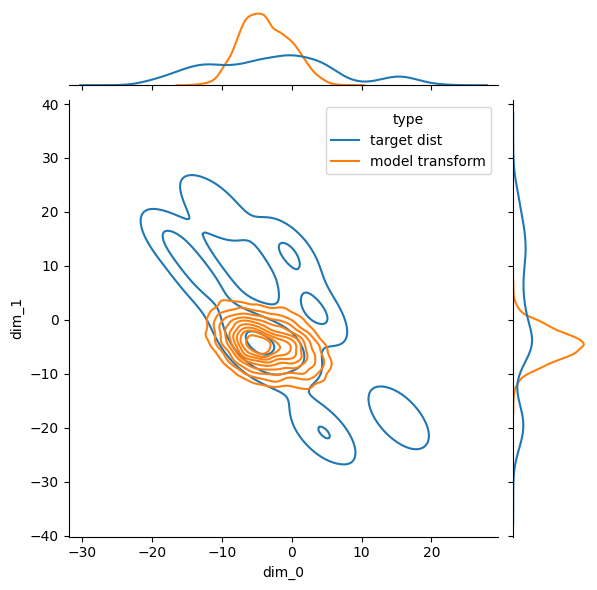

trail: 0 m step: 6 kl_test: 1.2814140319824219


 50%|█████     | 1000/2000 [14:21<15:55,  1.05it/s]

trail: 0 m step: 7 Loss: 1.286529541015625  L_n: 1.2571067810058594  kld: 0.014711380004882812 KLD1: 1.260610818862915 KLD2: 62.143436431884766


100%|██████████| 2000/2000 [28:42<00:00,  1.16it/s]

trail: 0 m step: 7 Loss: 1.2887153625488281  L_n: 1.2525711059570312  kld: 0.018072128295898438 KLD1: 1.2551077604293823 KLD2: 62.536705017089844



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


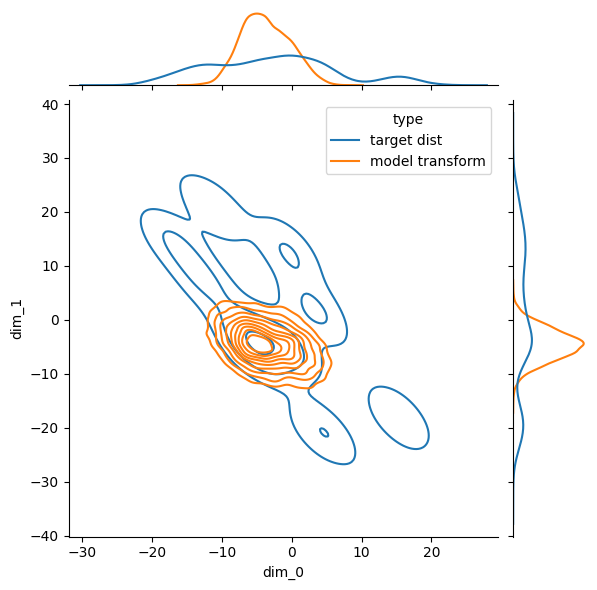

trail: 0 m step: 7 kl_test: 1.2501811981201172


 50%|█████     | 1000/2000 [14:20<15:56,  1.05it/s]

trail: 0 m step: 8 Loss: 1.259206771850586  L_n: 1.2417926788330078  kld: 0.008707046508789062 KLD1: 1.2455517053604126 KLD2: 64.68766021728516


100%|██████████| 2000/2000 [28:41<00:00,  1.16it/s]

trail: 0 m step: 8 Loss: 1.2593307495117188  L_n: 1.2451667785644531  kld: 0.0070819854736328125 KLD1: 1.2503761053085327 KLD2: 64.92449951171875



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


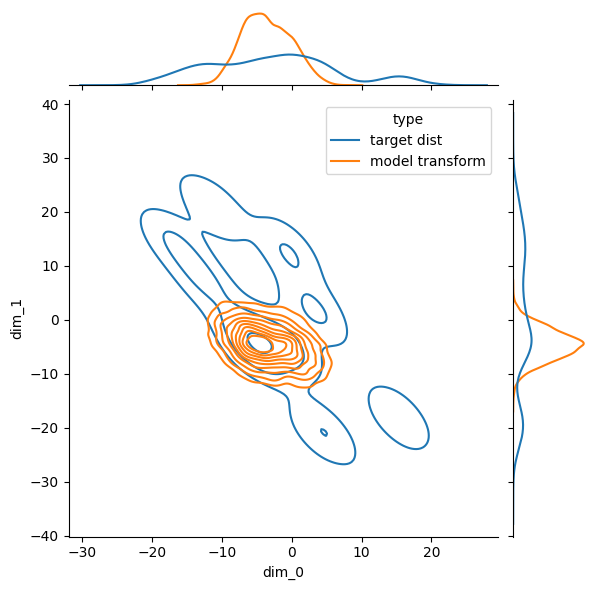

trail: 0 m step: 8 kl_test: 1.2539844512939453


 50%|█████     | 1000/2000 [14:20<15:52,  1.05it/s]

trail: 0 m step: 9 Loss: 1.2568225860595703  L_n: 1.2452564239501953  kld: 0.0057830810546875 KLD1: 1.2475082874298096 KLD2: 66.05369567871094


100%|██████████| 2000/2000 [28:39<00:00,  1.16it/s]

trail: 0 m step: 9 Loss: 1.3228282928466797  L_n: 1.249349594116211  kld: 0.036739349365234375 KLD1: 1.2600067853927612 KLD2: 66.21208953857422



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


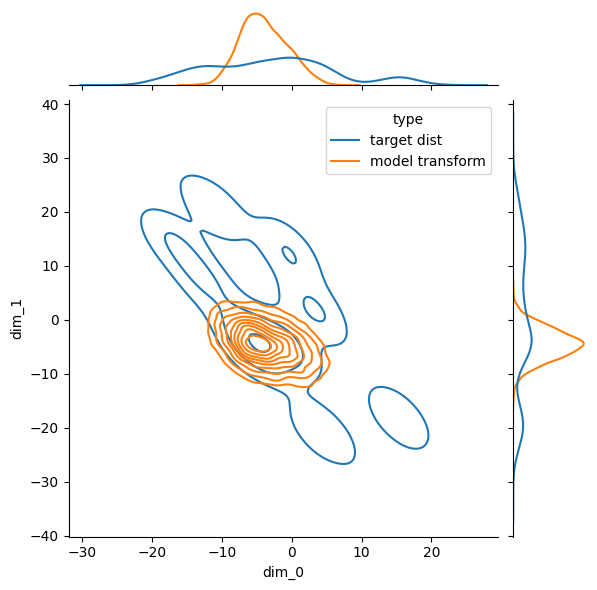

trail: 0 m step: 9 kl_test: 1.2492141723632812


 50%|█████     | 1000/2000 [14:19<15:54,  1.05it/s]

trail: 0 m step: 10 Loss: 1.2773399353027344  L_n: 1.260223388671875  kld: 0.008558273315429688 KLD1: 1.257071614265442 KLD2: 67.81103515625


100%|██████████| 2000/2000 [28:39<00:00,  1.16it/s]

trail: 0 m step: 10 Loss: 1.2844619750976562  L_n: 1.23785400390625  kld: 0.023303985595703125 KLD1: 1.2394262552261353 KLD2: 64.62957000732422



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


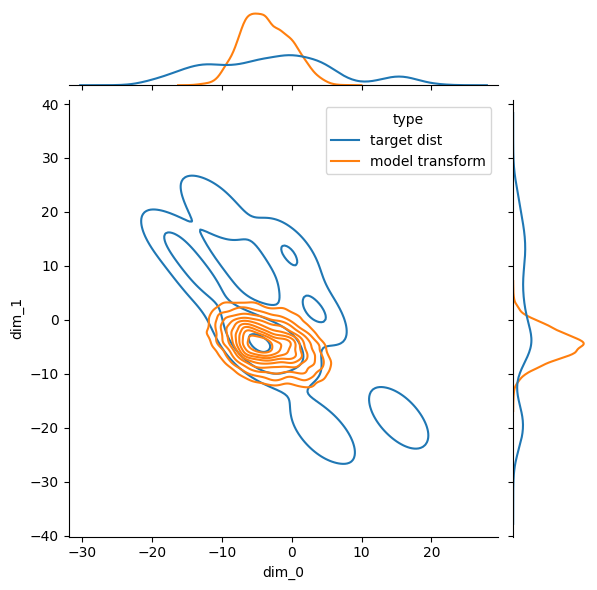

trail: 0 m step: 10 kl_test: 1.2438087463378906


 50%|█████     | 1000/2000 [14:19<15:55,  1.05it/s]

trail: 0 m step: 11 Loss: 1.2453632354736328  L_n: 1.2330493927001953  kld: 0.00615692138671875 KLD1: 1.2365416288375854 KLD2: 66.21307373046875


100%|██████████| 2000/2000 [28:39<00:00,  1.16it/s]

trail: 0 m step: 11 Loss: 1.2497291564941406  L_n: 1.2409553527832031  kld: 0.00438690185546875 KLD1: 1.2424240112304688 KLD2: 67.0885009765625



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


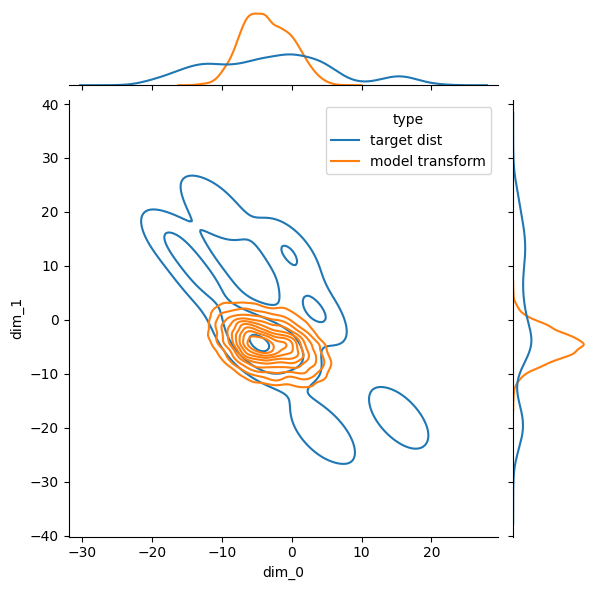

trail: 0 m step: 11 kl_test: 1.2474956512451172


 50%|█████     | 1000/2000 [14:20<15:55,  1.05it/s]

trail: 0 m step: 12 Loss: 1.2688121795654297  L_n: 1.2381572723388672  kld: 0.01532745361328125 KLD1: 1.2388863563537598 KLD2: 68.63402557373047


100%|██████████| 2000/2000 [28:40<00:00,  1.16it/s]

trail: 0 m step: 12 Loss: 1.2851200103759766  L_n: 1.2376041412353516  kld: 0.0237579345703125 KLD1: 1.239221215248108 KLD2: 66.27093505859375



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


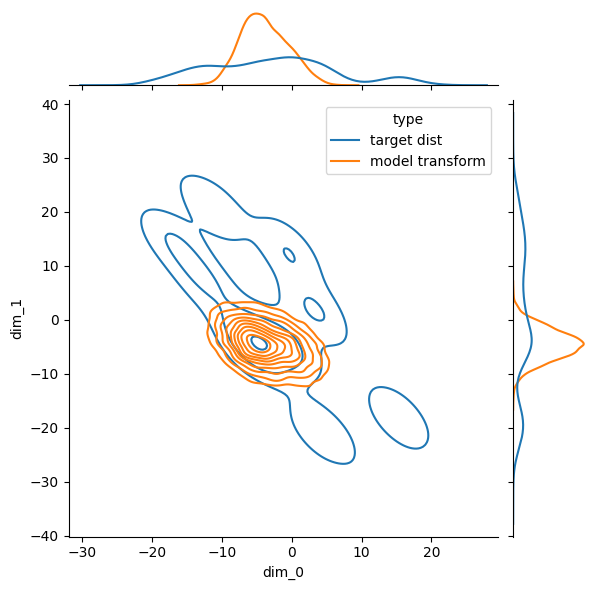

trail: 0 m step: 12 kl_test: 1.2378997802734375


 50%|█████     | 1000/2000 [14:20<15:55,  1.05it/s]

trail: 0 m step: 13 Loss: 1.2767486572265625  L_n: 1.2499122619628906  kld: 0.013418197631835938 KLD1: 1.238139271736145 KLD2: 68.19052124023438


100%|██████████| 2000/2000 [28:40<00:00,  1.16it/s]

trail: 0 m step: 13 Loss: 1.2498645782470703  L_n: 1.2399349212646484  kld: 0.0049648284912109375 KLD1: 1.2394554615020752 KLD2: 66.22086334228516



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


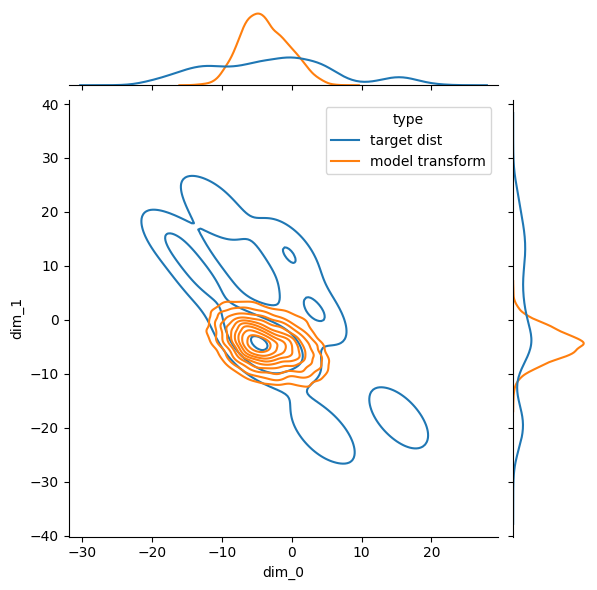

trail: 0 m step: 13 kl_test: 1.2385978698730469


 50%|█████     | 1000/2000 [14:19<15:54,  1.05it/s]

trail: 0 m step: 14 Loss: 1.3408203125  L_n: 1.2745285034179688  kld: 0.033145904541015625 KLD1: 1.2696558237075806 KLD2: 67.85906982421875


100%|██████████| 2000/2000 [28:39<00:00,  1.16it/s]

trail: 0 m step: 14 Loss: 1.261190414428711  L_n: 1.2413463592529297  kld: 0.009922027587890625 KLD1: 1.2474231719970703 KLD2: 68.59872436523438



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


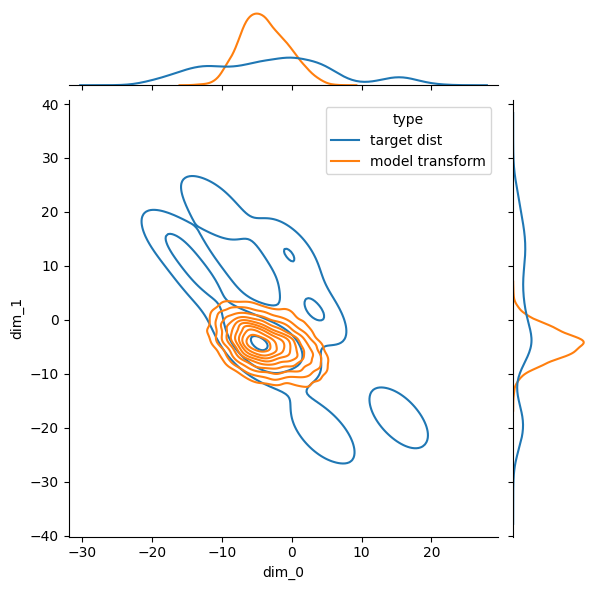

trail: 0 m step: 14 kl_test: 1.2429180145263672


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  lr_decay_factor = math.floor(mirror_itr/30) # decay the lr by 1/4 for every 30 mirror steps
  optimizer_lr_input = optimizer_lr * ((1/4 )** lr_decay_factor)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 1000 == 999:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


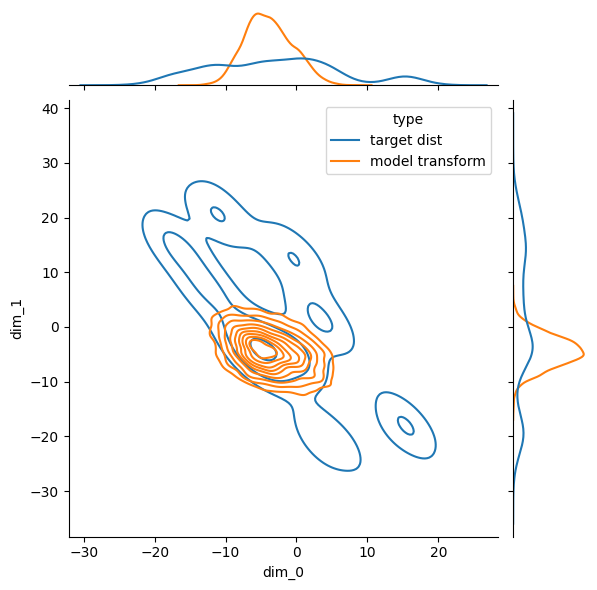

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())